In [1]:
import os
import math
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.measure import find_contours
from skimage.transform import rotate
from skimage.filters import median,gaussian
from skimage.morphology import disk,square,closing
from scipy import ndimage as ndi

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

### Load data

In [2]:
def rotate_operators(operators, nb_rotations) :
    """
    Input : (1x5x40x40) array of five operators concatenated
    Output : (Nx5x40x40)  N arrays of five operators where they have been rotated N times to reach 360
    """
    #calculate the array of angles of rotations
    angle = 360/nb_rotations
    angles = np.linspace(angle,360-angle,nb_rotations-1)
    
    for a in angles :
        operators_rotated = np.empty((1,5,40,40))
        for idx,op in enumerate(operators[0]) :
            # rotate operators with bi-cubic interpolation
            operators_rotated[0,idx] = rotate(op,a,order =5)
            # binarize the resulting rotated opearators
            thresh = threshold_otsu(operators_rotated[0,idx])
            operators_rotated[0,idx] = operators_rotated[0,idx]>thresh
            operators_rotated[0,idx] = operators_rotated[0,idx].astype(float)
            #operators_rotated[0,idx] = gaussian(operators_rotated[0,idx],sigma=0.5)
            #operators_rotated[0,idx] = operators_rotated[0,idx]>0.2
            
        # concatenate the five operators rotated by a certain angle to the array
        operators = np.concatenate([operators,operators_rotated],axis=0)
    return operators

In [3]:
def load_data(rotate=False,nb_rotation = 12) :
    """
    Load the five operators mask (40x40) -> plus,equal,minus,div,mul
    Output : (Nx5x40x40) array of operators :
                If no operators rotation : N=1 (1x5x40x40) -> [[plus,equal,minus,div,mul]]
                If operators are rotated : (Nx5x40x40) where N correspond to the number of rotation of each operator
                                            N = 360/ nb_rotation
    """
    
    # Load operators
    data_path = os.path.join('..\data')
    plus = skimage.io.imread(os.path.join(data_path, 'plus_bin.png'))
    equal = skimage.io.imread(os.path.join(data_path, 'equal_bin.png'))
    minus = skimage.io.imread(os.path.join(data_path, 'minus_bin.png'))
    div = skimage.io.imread(os.path.join(data_path, 'div_bin.png'))
    mul = skimage.io.imread(os.path.join(data_path, 'mul_bin.png'))
    
    # concatenate operators
    
    plus = np.expand_dims(plus,axis = 0)
    equal = np.expand_dims(equal,axis = 0)
    minus = np.expand_dims(minus,axis = 0)
    div = np.expand_dims(div,axis = 0)
    mul = np.expand_dims(mul,axis = 0)
    
    operators = np.concatenate([plus,equal,minus,div,mul], axis = 0)
    operators = np.expand_dims(operators,axis = 0)
    #rotation of the operators if true
    if (rotate == True) :
        operators = rotate_operators(operators,nb_rotation)
        
    return operators

In [4]:
operators = load_data(rotate=True)

C:\Users\seb\Anaconda3\envs\iapr2020\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\seb\Anaconda3\envs\iapr2020\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\seb\Anaconda3\envs\iapr2020\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Fig

C:\Users\seb\Anaconda3\envs\iapr2020\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\seb\Anaconda3\envs\iapr2020\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\seb\Anaconda3\envs\iapr2020\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Fig

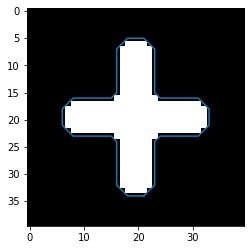

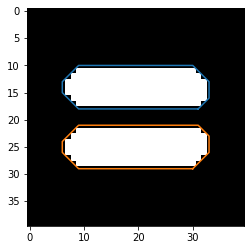

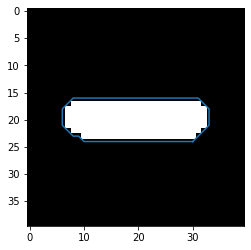

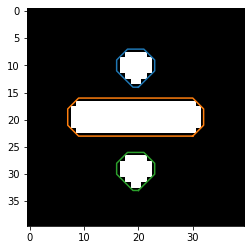

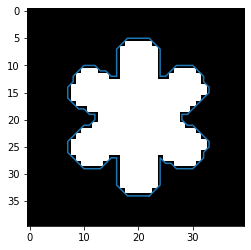

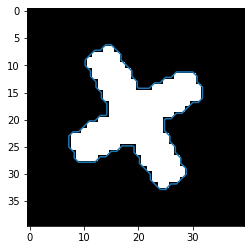

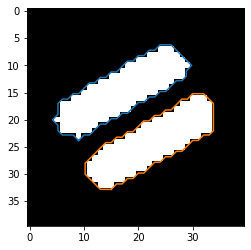

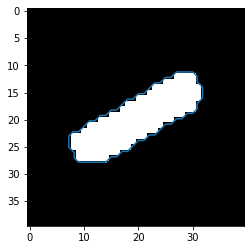

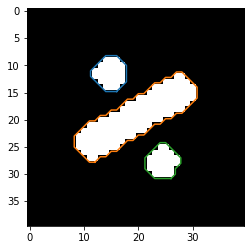

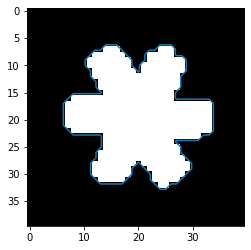

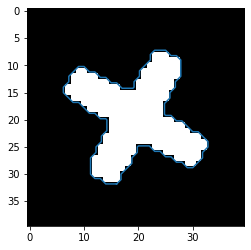

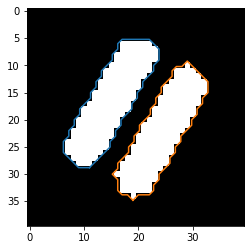

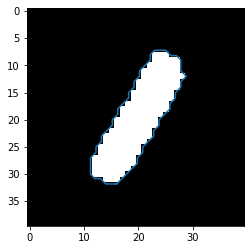

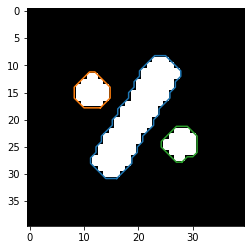

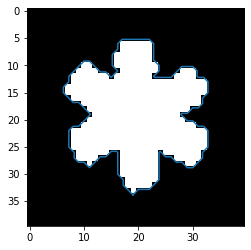

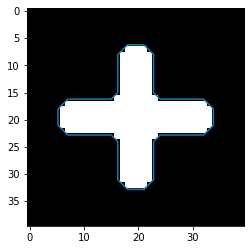

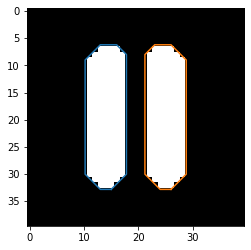

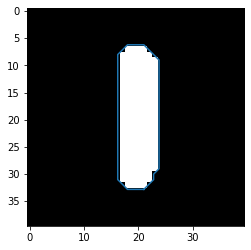

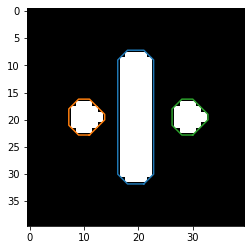

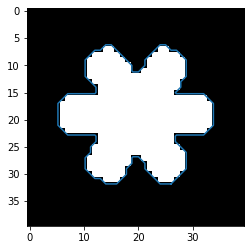

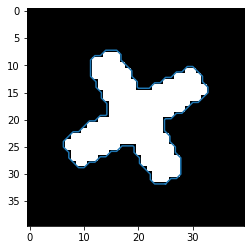

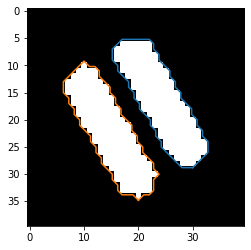

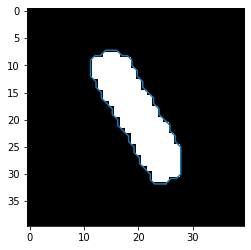

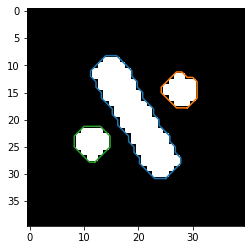

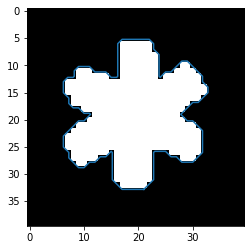

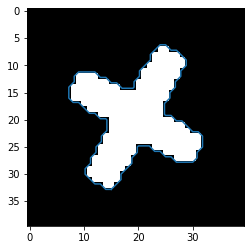

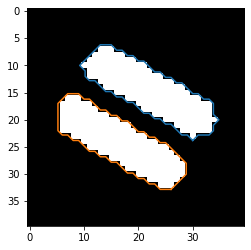

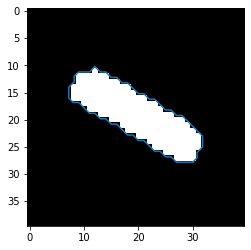

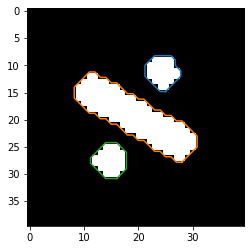

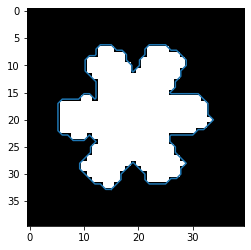

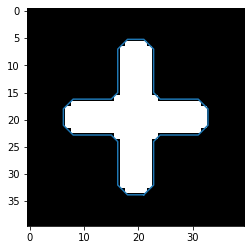

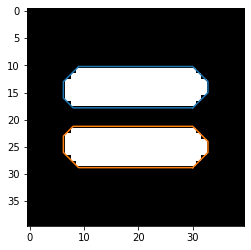

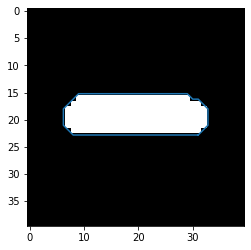

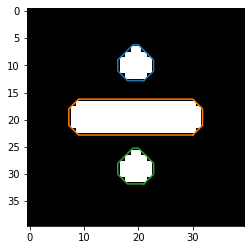

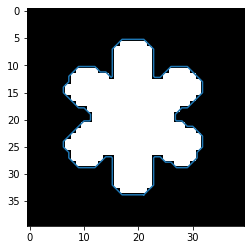

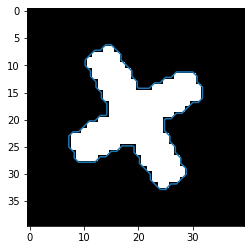

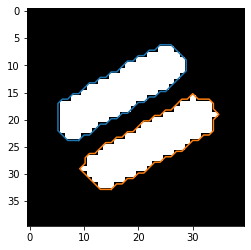

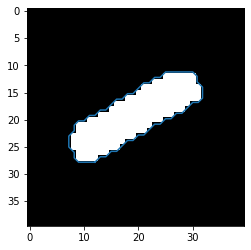

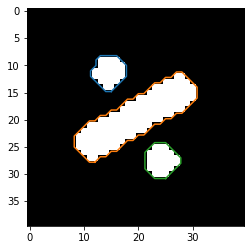

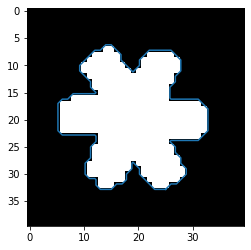

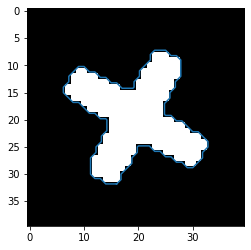

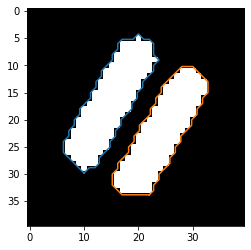

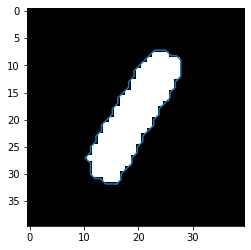

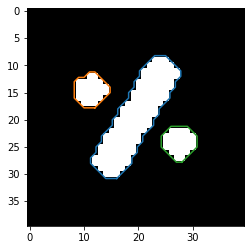

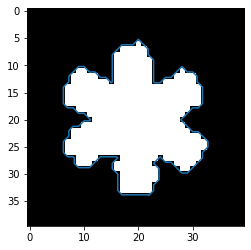

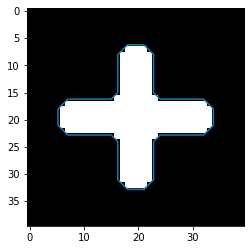

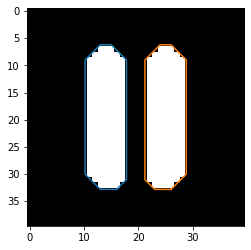

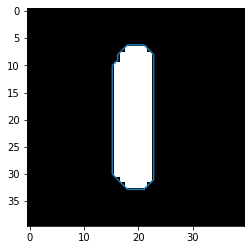

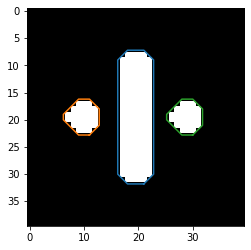

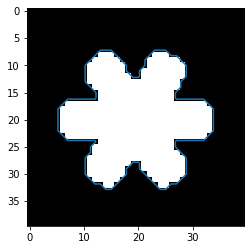

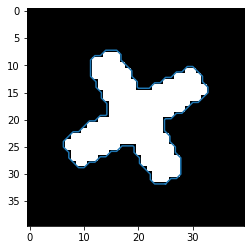

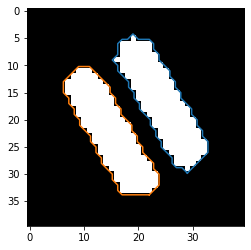

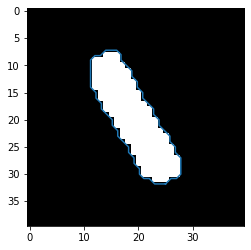

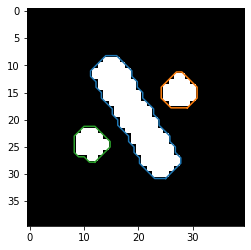

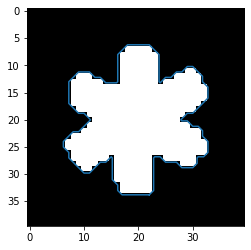

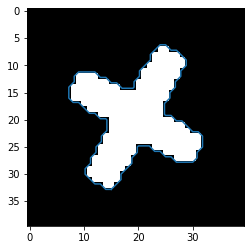

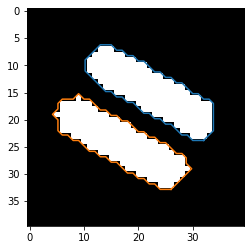

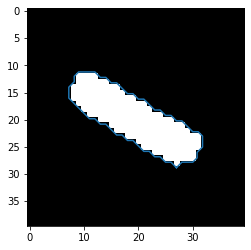

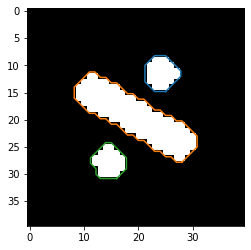

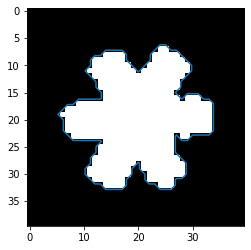

In [5]:
for n in range(operators.shape[0]) :
    for idx,op in enumerate(operators[n]) :
        plt.figure()
        plt.imshow(op,cmap='gray')
        contour1 = find_contours(op,0.2)
        plt.plot(contour1[0][:,1],contour1[0][:,0])
        if (len(contour1 )== 2) :
            plt.plot(contour1[1][:,1],contour1[1][:,0])
        if (len(contour1 )== 3) :
            plt.plot(contour1[1][:,1],contour1[1][:,0])
            plt.plot(contour1[2][:,1],contour1[2][:,0])

### Get features

In [6]:
def Fourier_descriptors (operators,Nb_coeff) :
    """
    Calculate the DFT of the operator's contour 
    Return the first N coefficient and the number of disjoint contours 
    """
    # get the contours
    contour = find_contours(operators,0.2)
    nb_contours = len(contour)
    if (nb_contours == 1) :
        contour = np.squeeze(np.asarray(contour))
        contour_complex = np.empty(contour.shape[0], dtype=complex)
        contour_complex.real = contour[:, 0]
        contour_complex.imag = contour[:, 1]
        fourier_result = np.fft.fft(contour_complex)
        DFT = np.fft.fft(contour_complex)
    if (nb_contours == 2) :
        contour_concatenated = np.concatenate((contour[0],contour[1]), axis=0)
        contour_complex = np.empty(contour_concatenated.shape[0], dtype=complex)
        contour_complex.real = contour_concatenated[:, 1]
        contour_complex.imag = contour_concatenated[:, 0]
        DFT = np.fft.fft(contour_complex)
    if (nb_contours == 3) :
        contour_concatenated = np.concatenate((contour[0],contour[1],contour[2]), axis=0)
        contour_complex = np.empty(contour_concatenated.shape[0], dtype=complex)
        contour_complex.real = contour_concatenated[:, 1]
        contour_complex.imag = contour_concatenated[:, 0]
        DFT = np.fft.fft(contour_complex)
    
    return DFT[:Nb_coeff], nb_contours

In [38]:
def get_features(operators,Nb_coeff,target =False ) :
    """
    Input : (Nx5x40x40) arrays of operators 
    Output : (5Nx4) arrays of features and (5N) arrays of target
            Features : First three features are ratio of the amplitude of fourier descriptor -> [A1/A2,A3/A2,A4/A2]
                       Last features is the number of disjoint contour -> plus,minus,mul : 1, equal : 2, div :3
    """
    
    # initialize the arrrays
    features = np.empty((operators.shape[0],operators.shape[1],4))
    targets = np.empty((operators.shape[0],5))
    print(operators.shape[0])
    #Loop over the array of operators to get the features and targets
    for N in range(operators.shape[0]):
        for idx,op in enumerate(operators[N]):
            coeff,nb_contours = Fourier_descriptors(op,Nb_coeff)
            A1 = np.sqrt(coeff[1].real**2+coeff[1].imag**2)
            A2 = np.sqrt(coeff[2].real**2+coeff[2].imag**2)
            A3 = np.sqrt(coeff[3].real**2+coeff[3].imag**2)
            A4 = np.sqrt(coeff[4].real**2+coeff[4].imag**2)
            A5 = np.sqrt(coeff[5].real**2+coeff[5].imag**2)
            # compute ratios of Fourier descriptors -> scale invariant
            coord_x = (A1/A5)
            coord_y = (A2/A5)
            coord_z = (A3/A4)
            #coord_w = (A4/A5)
            #coord_v = (A5/A0)
            # concatenate the features 
            features[N,idx] = np.array([coord_x,coord_y,coord_z,nb_contours])
            targets[N,idx] = idx
    # reshape the arrays for the classification algorithm
    features = np.reshape(features,(operators.shape[0]*operators.shape[1],4))
    targets = np.reshape(targets,(operators.shape[0]*5))
    if (target == False) :
        return features
    if(target == True) :
        return features,targets

In [32]:
features,targets = get_features(operators,6,True)
print(features.shape)
print(targets.shape)

12
(60, 4)
(60,)


In [33]:
def plot_two_Fourier_descriptor(features , target, coeff1,coeff2 ) :
    
    for idx,t in enumerate(target) : 
        if (t == 0) :
            add = plt.scatter(features[idx,coeff1],features[idx,coeff2],c='red')
        #if (t == 1) :
            #equal = plt.scatter(features[idx,coeff1],features[idx,coeff2],c='blue')
        if (t == 2) :
            minus = plt.scatter(features[idx,coeff1],features[idx,coeff2],c='orange')
        #if (t == 3) :
            #div = plt.scatter(features[idx,coeff1],features[idx,coeff2],c='green')
        if (t == 4) :
            mul = plt.scatter(features[idx,coeff1],features[idx,coeff2],c='purple')
    
    plt.legend((add,minus,mul),('add','minus','mul'))

Text(0.996475263380316, 5.6009415133920095, 'minus')

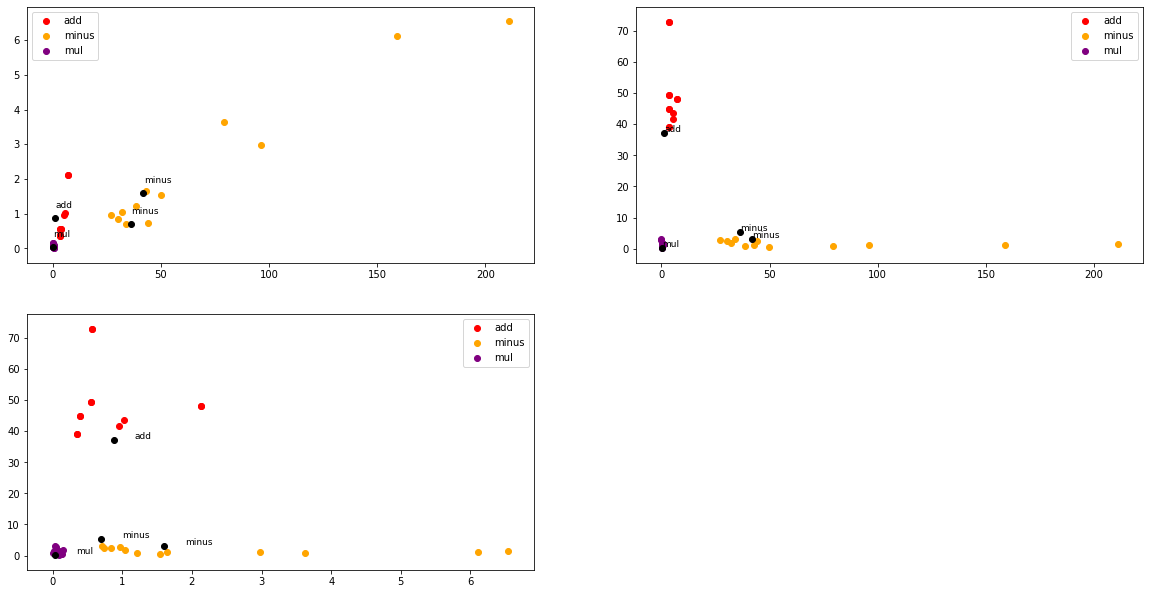

In [51]:
plt.figure(figsize=(20,16))
plt.subplot(321)
plot_two_Fourier_descriptor(features , targets,0,1 )
plt.scatter(features_minus[0],features_minus[1],c ='black')
plt.text(features_minus[0]+0.3, features_minus[1]+0.3, 'minus', fontsize=9)
plt.scatter(features_crop[1,0],features_crop[1,1],c ='black')
plt.text(features_crop[1,0]+0.3, features_crop[1,1]+0.3, 'add', fontsize=9)
plt.scatter(features_crop[2,0],features_crop[2,1],c ='black')
plt.text(features_crop[2,0]+0.3, features_crop[2,1]+0.3, 'mul', fontsize=9)
plt.scatter(features_minus2[0],features_minus2[1],c ='black')
plt.text(features_minus2[0]+0.3, features_minus2[1]+0.3, 'minus', fontsize=9)
plt.subplot(322)
plot_two_Fourier_descriptor(features , targets,0,2 )
plt.scatter(features_minus[0],features_minus[2],c ='black')
plt.text(features_minus[0]+0.3, features_minus[2]+0.3, 'minus', fontsize=9)
plt.scatter(features_crop[1,0],features_crop[1,2],c ='black')
plt.text(features_crop[1,0]+0.3, features_crop[1,2]+0.3, 'add', fontsize=9)
plt.scatter(features_crop[2,0],features_crop[2,2],c ='black')
plt.text(features_crop[2,0]+0.3, features_crop[2,2]+0.3, 'mul', fontsize=9)
plt.scatter(features_minus2[0],features_minus2[2],c ='black')
plt.text(features_minus2[0]+0.3, features_minus2[2]+0.3, 'minus', fontsize=9)
plt.subplot(323)
plot_two_Fourier_descriptor(features , targets,1,2 )
plt.scatter(features_minus[1],features_minus[2],c ='black')
plt.text(features_minus[1]+0.3, features_minus[2]+0.3, 'minus', fontsize=9)
plt.scatter(features_crop[1,1],features_crop[1,2],c ='black')
plt.text(features_crop[1,1]+0.3, features_crop[1,2]+0.3, 'add', fontsize=9)
plt.scatter(features_crop[2,1],features_crop[2,2],c ='black')
plt.text(features_crop[2,1]+0.3, features_crop[2,2]+0.3, 'mul', fontsize=9)
plt.scatter(features_minus2[1],features_minus2[2],c ='black')
plt.text(features_minus2[1]+0.3, features_minus2[2]+0.3, 'minus', fontsize=9)

In [15]:
def biggest_label(properties):
    # assigns to max_lab the biggest labeled object on the image
    max_lab = properties[0]
    for lab in properties:
        if lab.area > max_lab.area:
            max_lab = lab
    return max_lab

In [16]:
def region_based_descr(bin_im):
    # compute all region-based descriptors 
    labels = label(bin_im)
    biggest_lab = biggest_label(regionprops(labels))
    area = biggest_lab.area
    perimeter = biggest_lab.perimeter
    compacity = perimeter**2 / area 
    convex_area = biggest_lab.convex_area
    filled_area = biggest_lab.filled_area
    h_projection = np.count_nonzero(sum(bin_im, 0))
    elongation = math.sqrt(inertia_tensor_eigvals(bin_im)[0]/inertia_tensor_eigvals(bin_im)[1])
    h_variance = inertia_tensor(bin_im)[0,0]
    v_variance = inertia_tensor(bin_im)[1,1]
    moment = moments(bin_im)
    gravCenter = (moments(bin_im)[1, 0] / moments(bin_im)[0, 0], moments(bin_im)[0, 1] / moments(bin_im)[0, 0])
    
    return compacity, area, convex_area, perimeter, filled_area, h_projection, elongation, h_variance, v_variance, moment, gravCenter

In [17]:
def plot_region_based_descr(images_sets, names, colors): 
    fig, axes = plt.subplots(6, 2, figsize=(18, 36))
    ax = axes.ravel()
    
    for idx, im_set in enumerate(images_sets):
        for ind,im in enumerate(im_set):
            comp, area, convex_area, perimeter, filled_area, h_projection, elongation, h_variance, v_variance, moment, gravCenter = region_based_descr(im)
            ax[0].scatter(comp,area,c=colors[ind])
            ax[1].scatter(convex_area,area,c=colors[ind])
            ax[2].scatter(perimeter,area,c=colors[ind])
            ax[3].scatter(filled_area,area,c=colors[ind])
            ax[4].scatter(filled_area,perimeter,c=colors[ind])
            ax[5].scatter(comp,perimeter,c=colors[ind])
            ax[6].scatter(h_projection,area,c=colors[ind])
            ax[7].scatter(elongation,area,c=colors[ind])
            ax[8].scatter(h_variance,v_variance,c=colors[ind])
            ax[9].scatter(gravCenter[0],gravCenter[1],c=colors[ind])
            ax[10].scatter(moment[0, 0],moment[3, 3],c=colors[ind])
            ax[11].scatter(moment[0, 1],moment[2, 3],c=colors[ind])
    
    # Legend, title, axe labels
    legend_el = []
    for ind in range(len(colors)):    
        legend_el.append(Line2D([0], [0], marker='o', color='w', label=names[ind], markerfacecolor=colors[ind], markersize=8))
    
    ax[0].legend(handles=legend_el)
    ax[1].legend(handles=legend_el)
    ax[2].legend(handles=legend_el)
    ax[3].legend(handles=legend_el)
    ax[4].legend(handles=legend_el)
    ax[5].legend(handles=legend_el)
    ax[6].legend(handles=legend_el)
    ax[7].legend(handles=legend_el)
    ax[8].legend(handles=legend_el)
    ax[9].legend(handles=legend_el)
    ax[10].legend(handles=legend_el)
    ax[11].legend(handles=legend_el)
            
        
    ax[0].set_title("Compacity VS area")
    ax[1].set_title("Convex area VS area")
    ax[2].set_title("Perimeter VS area")
    ax[3].set_title("Filled area VS area")
    ax[4].set_title("Filled area VS perimeter")
    ax[5].set_title("Compacity VS perimeter")
    ax[6].set_title("Horizontal projection VS area")
    ax[7].set_title("Elongation VS area")
    ax[8].set_title("Horizontal variance VS vertical variance")
    ax[9].set_title("Gravity center")
    ax[10].set_title("Moment [0,0] VS moment [3,3]")
    ax[11].set_title("Moment [0,1] VS moment [2,3]")
    
    
    ax[0].set_xlabel('compacity')
    ax[1].set_xlabel('convex area')
    ax[2].set_xlabel('perimeter')
    ax[3].set_xlabel('filled area')
    ax[4].set_xlabel('filled area')
    ax[5].set_xlabel('compacity')
    ax[6].set_xlabel('horizontal projection')
    ax[7].set_xlabel('elongation')
    ax[8].set_xlabel('horizontal variance')
    ax[9].set_xlabel('grav center x')
    ax[10].set_xlabel('moment [0,0]')
    ax[11].set_xlabel('moment [0,1]')
    
    
    ax[0].set_ylabel('area')
    ax[1].set_ylabel('area')
    ax[2].set_ylabel('area')
    ax[3].set_ylabel('area')
    ax[4].set_ylabel('perimeter')
    ax[5].set_ylabel('perimeter')
    ax[6].set_ylabel('area')
    ax[7].set_ylabel('area')
    ax[8].set_ylabel('vertical variance')
    ax[9].set_ylabel('grav center y')
    ax[10].set_ylabel('moment [3,3]')
    ax[11].set_ylabel('moment [2,3]')
    
    plt.tight_layout()
    plt.show() 

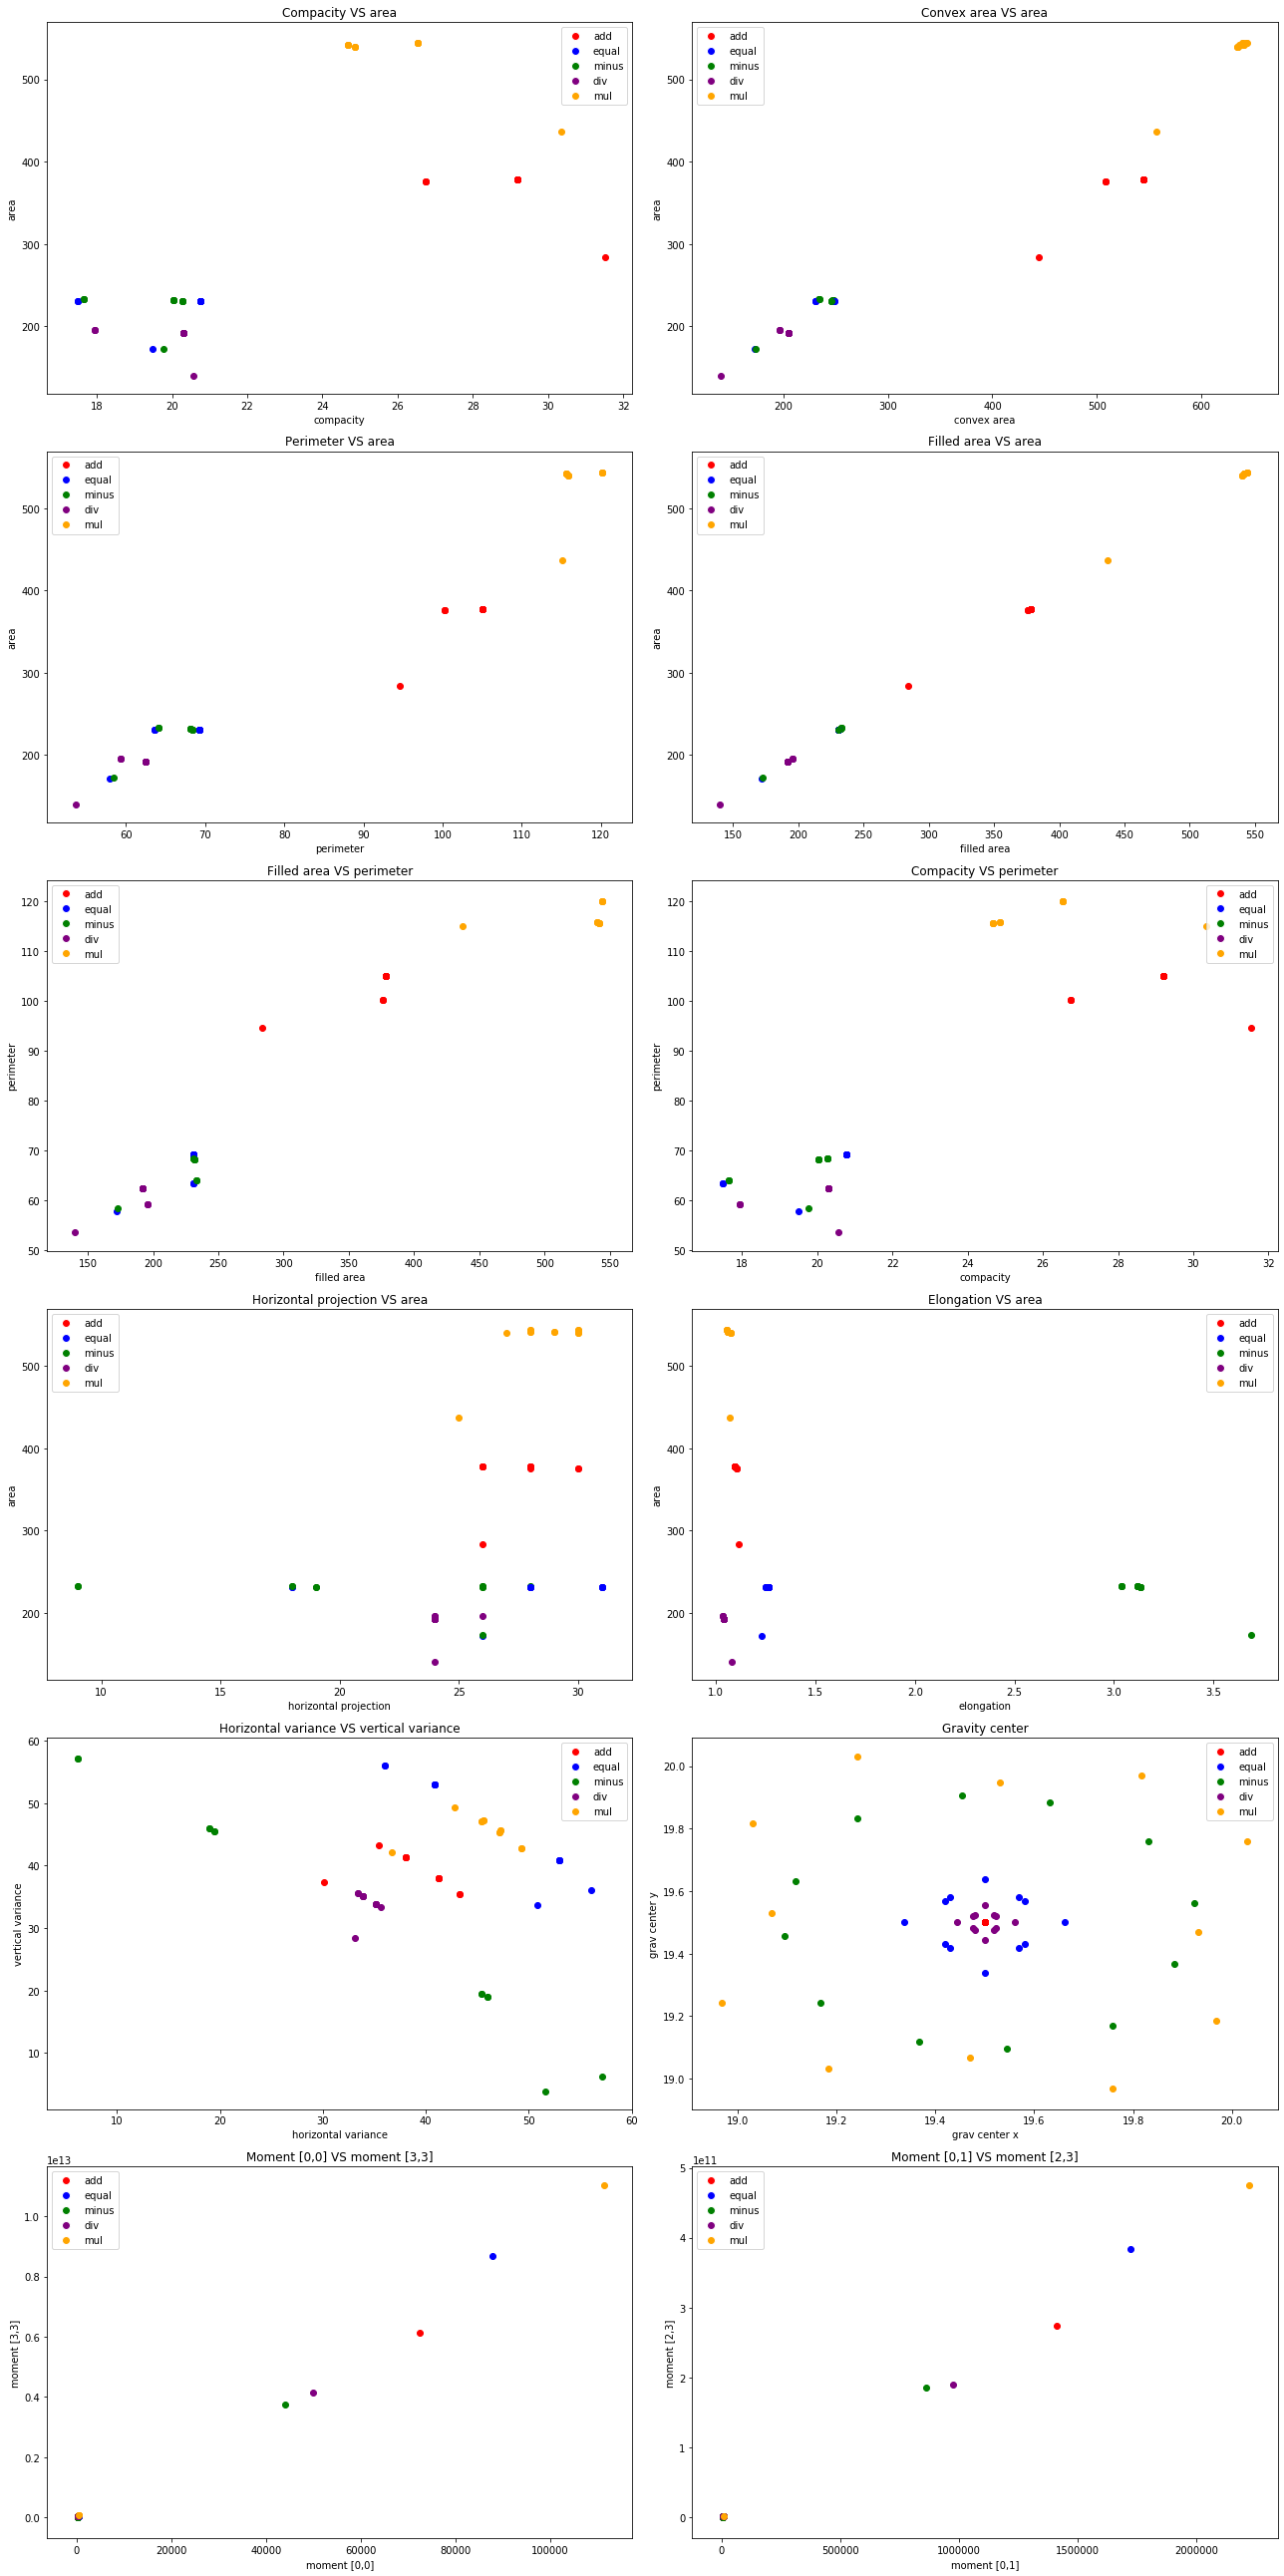

In [18]:
from skimage.measure import label, regionprops, find_contours
from skimage.measure import inertia_tensor, inertia_tensor_eigvals
from skimage.measure import moments, moments_normalized, moments,moments_central
from matplotlib.lines import Line2D
colors = ['red', 'blue','green','purple','orange']
names = ['add','equal','minus','div','mul']
plot_region_based_descr(operators, names, colors)

### K-nearest_neighbors classifier

In [10]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features,targets, test_size=0.2, random_state=1)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 0.8333333333333334, 0.75, 0.6666666666666666, 0.6666666666666666, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]


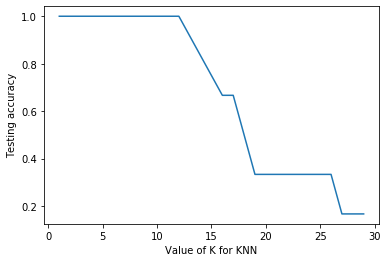

In [11]:
k_range = range(1,30)
scores = {}
scores_list = []
for k in k_range :
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test,y_pred)
    scores_list.append(metrics.accuracy_score(y_test,y_pred))
    
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing accuracy')
print(scores_list)

In [12]:
#create new a knn model
knn_GS = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 20)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn_GS, param_grid, cv=5)
#fit model to data
knn_gscv.fit(features, targets)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [13]:
#check top performing n_neighbors value
print(knn_gscv.best_params_)
#check mean score for the top performing value of n_neighbors
print(knn_gscv.best_score_)

{'n_neighbors': 1}
1.0


In [14]:
# check result
print(knn_gscv.cv_results_)

{'mean_fit_time': array([0.0006    , 0.00080004, 0.00100007, 0.00080009, 0.00059996,
       0.00060005, 0.00080013, 0.00080013, 0.00040007, 0.00020003,
       0.00059996, 0.00039997, 0.00019999, 0.00019999, 0.00060005,
       0.00060005, 0.00060005, 0.00059996, 0.00040011]), 'std_fit_time': array([4.89901382e-04, 4.00018706e-04, 1.16800773e-07, 4.00042573e-04,
       4.89862441e-04, 4.89940316e-04, 4.00066404e-04, 4.00066376e-04,
       4.89979242e-04, 4.00066376e-04, 4.89862441e-04, 4.89862441e-04,
       3.99971008e-04, 3.99971008e-04, 4.89940316e-04, 4.89940316e-04,
       4.89940316e-04, 4.89862441e-04, 4.90037648e-04]), 'mean_score_time': array([0.00200014, 0.0012001 , 0.00220008, 0.00140009, 0.00160012,
       0.00160017, 0.00140004, 0.00119991, 0.00100007, 0.00140014,
       0.00100012, 0.00100021, 0.00120006, 0.00120001, 0.00119996,
       0.00120001, 0.0012001 , 0.0012001 , 0.00180006]), 'std_score_time': array([6.32485089e-04, 3.99994861e-04, 3.99971008e-04, 4.89901382e-04,
 

In [15]:
# from gridsearchCV -> 1-NN best (but if look at result 1 to 18 yield 100 accuracy)
knn_tuned = KNeighborsClassifier(n_neighbors = 5)
knn_tuned.fit(features, targets)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [16]:
classes = {0:'addition',1:'equal',2:'minus',3:'division',4:'multiplication'}

In [17]:
# Load unseen operators
data_path = os.path.join('..\data')
plus_ = skimage.io.imread(os.path.join(data_path, 'plus.png'))
equal_ = skimage.io.imread(os.path.join(data_path, 'equal.png'))
minus_ = skimage.io.imread(os.path.join(data_path, 'minus.png'))
div_ = skimage.io.imread(os.path.join(data_path, 'div.png'))
mul_ = skimage.io.imread(os.path.join(data_path, 'mul.png'))

#thresh = threshold_otsu(operators_rotated[0,idx])
#operators_rotated[0,idx] = operators_rotated[0,idx]>thresh
#operators_rotated[0,idx] = operators_rotated[0,idx].astype(float)

plus_ = np.expand_dims(plus_,axis = 0)
equal_ = np.expand_dims(equal_,axis = 0)
minus_ = np.expand_dims(minus_,axis = 0)
div_ = np.expand_dims(div_,axis = 0)
mul_ = np.expand_dims(mul_,axis = 0)
    
operators_ = np.concatenate([plus_,equal_,minus_,div_,mul_], axis = 0)
operators_ = np.expand_dims(operators_,axis = 0)

for N in range(operators_.shape[0]) :
    for idx,op in enumerate(operators_[N]) : 
        thresh = threshold_otsu(op)
        op = op>thresh
        operators_[N,idx] = op.astype(float)
        

# get features

features_unseen = get_features(operators_,6)
print(features_unseen)

1
[[ 5.16595534  0.94711492 23.53288386  1.        ]
 [ 4.23352993 11.18619724  1.79087454  2.        ]
 [27.71329036  0.77256949  1.45697578  1.        ]
 [ 0.90300627  4.32286135  0.82337725  3.        ]
 [ 0.11336343  0.04645121  0.09114413  1.        ]]


In [18]:
y_predict = knn_tuned.predict(features_unseen)

In [19]:
for y in y_predict:
    print(classes[y])

addition
equal
minus
division
multiplication


1
[[1.49848874e+00 5.00249551e+00 8.10825460e-01 3.00000000e+00]
 [1.08679417e+00 8.74330563e-01 3.71328248e+01 1.00000000e+00]
 [1.27241067e-01 3.10020889e-02 1.92485351e-01 1.00000000e+00]
 [5.46893994e+00 1.00534486e+01 1.67566658e+01 2.00000000e+00]]


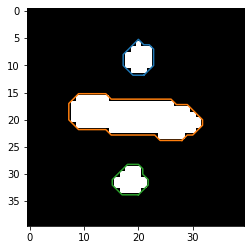

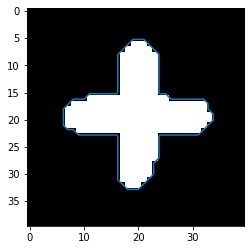

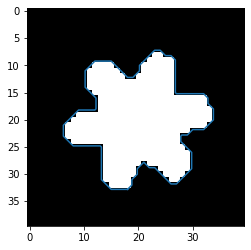

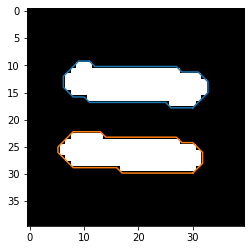

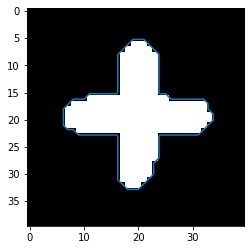

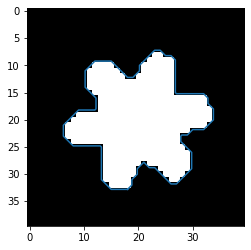

In [35]:
# operators cropped from the video
data_path = os.path.join('..\data')
crop1= skimage.io.imread(os.path.join(data_path, 'crop1.png'))
crop2 = skimage.io.imread(os.path.join(data_path, 'crop2.png'))
crop3 = skimage.io.imread(os.path.join(data_path, 'crop3.png'))
crop4 = skimage.io.imread(os.path.join(data_path, 'crop4.png'))

from skimage.color import rgb2gray
# convert in rgb in bw images 
crop1 = rgb2gray(crop1)
crop2 = rgb2gray(crop2)
crop3 = rgb2gray(crop3)
crop4 = rgb2gray(crop4)


# extend dim and concatenate
crop1 = np.expand_dims(crop1,axis = 0)
crop2 = np.expand_dims(crop2,axis = 0)
crop3 = np.expand_dims(crop3,axis = 0)
crop4 = np.expand_dims(crop4,axis = 0)
crop_operators = np.concatenate([crop1,crop2,crop3,crop4], axis = 0)
crop_operators = np.expand_dims(crop_operators,axis = 0)

#print(crop_operators.shape)
from skimage.transform import resize

crop_operators_resized = np.empty((1,4,40,40))

for N in range(crop_operators.shape[0]) :
    for idx,op in enumerate(crop_operators[N]) : 
        op = resize(op,(40,40), anti_aliasing = True)
        thresh = threshold_otsu(op)
        op = op<thresh
        plt.figure()
        plt.imshow(op,cmap='gray')
        contour1 = find_contours(op,0.2)
        plt.plot(contour1[0][:,1],contour1[0][:,0])
        if (len(contour1 )== 2) :
            plt.plot(contour1[1][:,1],contour1[1][:,0])
        if (len(contour1 )== 3) :
            plt.plot(contour1[1][:,1],contour1[1][:,0])
            plt.plot(contour1[2][:,1],contour1[2][:,0])
        crop_operators_resized[N,idx] = op.astype(float)
#print(crop_operators_resized.shape)

plt.figure()
plt.imshow(crop_operators_resized[0,1],cmap='gray')
contour1 = find_contours(crop_operators_resized[0,1],0.2)
#print(contour1[0][:,1])
plt.plot(contour1[0][:,1],contour1[0][:,0])
plt.figure()
plt.imshow(crop_operators_resized[0,2],cmap='gray')
contour = find_contours(crop_operators_resized[0,2],0.2)
#print(contour[0][:,1])
plt.plot(contour[0][:,1],contour[0][:,0])

# get features

features_crop = get_features(crop_operators_resized,6)
print(features_crop)

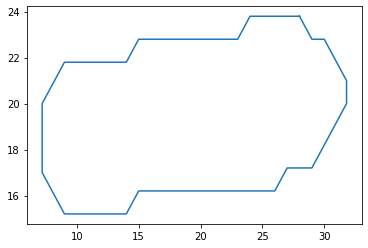

In [46]:
contour_minus = find_contours(crop_operators_resized[0,0],0.2)
plt.plot(contour_minus[1][:, 1],contour_minus[1][:, 0])
contour_complex = np.empty(contour_minus[1].shape[0], dtype=complex)
contour_complex.real = contour_minus[1][:, 0]
contour_complex.imag = contour_minus[1][:, 1]
fourier_result = np.fft.fft(contour_complex)
DFT = np.fft.fft(contour_complex)
coeff = DFT[:6]
A1 = np.sqrt(coeff[1].real**2+coeff[1].imag**2)
A2 = np.sqrt(coeff[2].real**2+coeff[2].imag**2)
A3 = np.sqrt(coeff[3].real**2+coeff[3].imag**2)
A4 = np.sqrt(coeff[4].real**2+coeff[4].imag**2)
A5 = np.sqrt(coeff[5].real**2+coeff[5].imag**2)
# compute ratios of Fourier descriptors -> scale invariant
coord_x = (A1/A5)
coord_y = (A2/A5)
coord_z = (A3/A4)
#coord_w = (A4/A5)
#coord_v = (A5/A0)
# concatenate the features 
features_minus = np.array([coord_x,coord_y,coord_z])

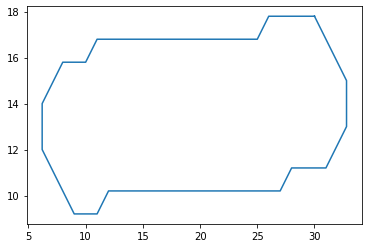

In [47]:
contour_minus2 = find_contours(crop_operators_resized[0,3],0.2)
plt.plot(contour_minus2[0][:, 1],contour_minus2[0][:, 0])
contour_complex = np.empty(contour_minus2[0].shape[0], dtype=complex)
contour_complex.real = contour_minus2[0][:, 0]
contour_complex.imag = contour_minus2[0][:, 1]
fourier_result = np.fft.fft(contour_complex)
DFT = np.fft.fft(contour_complex)
coeff = DFT[:6]
A1 = np.sqrt(coeff[1].real**2+coeff[1].imag**2)
A2 = np.sqrt(coeff[2].real**2+coeff[2].imag**2)
A3 = np.sqrt(coeff[3].real**2+coeff[3].imag**2)
A4 = np.sqrt(coeff[4].real**2+coeff[4].imag**2)
A5 = np.sqrt(coeff[5].real**2+coeff[5].imag**2)
# compute ratios of Fourier descriptors -> scale invariant
coord_x = (A1/A5)
coord_y = (A2/A5)
coord_z = (A3/A4)
#coord_w = (A4/A5)
#coord_v = (A5/A0)
# concatenate the features 
features_minus2 = np.array([coord_x,coord_y,coord_z])

In [21]:
y_predict_crop = knn_tuned.predict(features_crop)

for y_crop in y_predict_crop:
    print(y_crop)
    print(classes[y_crop])

3.0
division
0.0
addition
4.0
multiplication
1.0
equal


In [31]:
labels_add = label(crop_operators_resized[0,1])
biggest_lab_add = biggest_label(regionprops(labels_add))
area_add = biggest_lab_add.area
perimeter_add = biggest_lab_add.perimeter
compacity_add = perimeter_add**2 / area_add 
labels_mul = label(crop_operators_resized[0,2])
biggest_lab_mul = biggest_label(regionprops(labels_mul))
area_mul = biggest_lab_mul.area
perimeter_mul = biggest_lab_mul.perimeter
compacity_mul = perimeter_mul**2 / area_mul

In [32]:
print(area_add)
print(area_mul)
print(compacity_add)
print(compacity_mul)
print(perimeter_add)
print(perimeter_mul)

294
387
29.336216375618104
27.237553815325473
92.87005768508881
102.66904755831213
